In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import lmfit
import ompy as om
import json

import scipy.stats as stats
import scipy.integrate as integrate
import scipy.constants as constants
import sys

#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
from ipynb.fs.full.functions import *

In [3]:
#setting figsize
plt.rcParams["figure.figsize"] = (8,6)

plt.rcParams["figure.autolayout"] = True

#size of marker and errorbar caps
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["lines.markersize"] = 5

#setting label sizes
plt.rcParams['font.size'] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 16


#set linewidths and markersize
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['lines.markersize'] = 10

#set x and y axis
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.top'] = True

plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 1.5
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['legend.frameon'] = False

#setting different dpi for notebook and saving
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.dpi"] = 80

In [4]:
om.__full_version__;
np.random.seed(1382398)

In [5]:
#gsf_values = read_OMPy('02-23_13:03:23')[0]
#gsf_values = read_OMPy('02-23_14:54:21')[0]
#gsf_values = read_OMPy('02-23_14:08:46')[0] #180kev/bin
gsf_values = read_OMPy('03-02_11:19:18')[0] #185 kev/bin
#gsf_values = read_OMPy('03-01_11:35:59')[0] #120 kev/bin

#-3 removes the lsst three points from this analysis, as they are very uncertain
energy_gsf_ompy = np.asarray(gsf_values[0][0:-3])
gsf_ompy_median = np.asarray(gsf_values[1][0:-3])
gsf_ompy_error_old = np.asarray([gsf_values[4][0][0:-3], gsf_values[4][1][0:-3]])

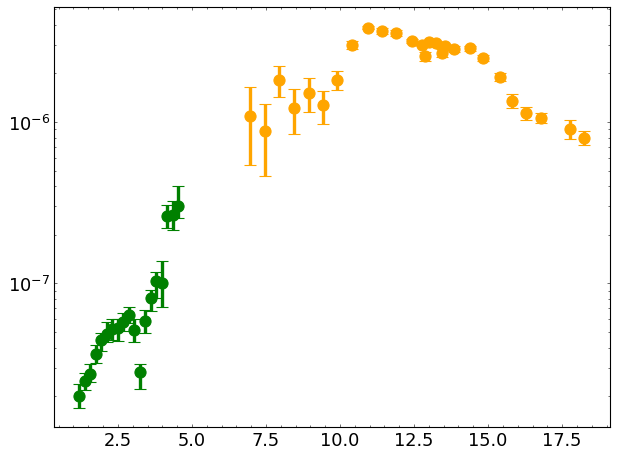

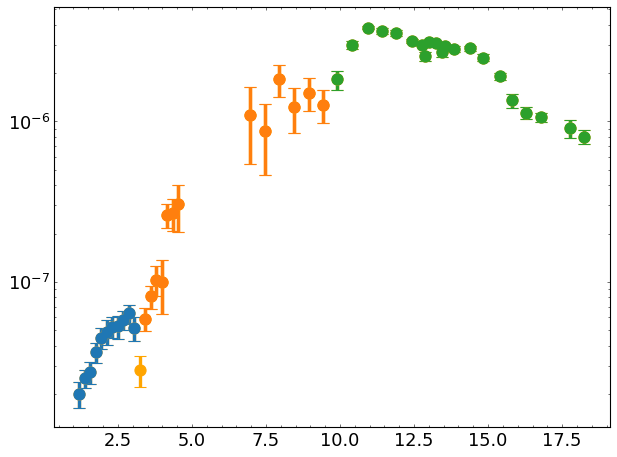

In [6]:
with open('u234_g_x.json') as K:
    data_U233 = json.load(K)
datasets_U233=data_U233["datasets"]

energy_exp1, gsf_exp1, gsf_exp1_error =  extract_JSON(datasets_U233[0]['data'], 5, 0, 1)
gsf_exp1 = cs_to_gsf(energy_exp1, gsf_exp1)
gsf_exp1_error = cs_to_gsf(energy_exp1, gsf_exp1_error)

fig, ax = plt.subplots()
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error_old, fmt='o', color='green')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='orange')
ax.set_yscale('log')
fig.show()

#pasting all data together


#changing the errors, to one array instead of two
#new array are now the maximum of the upper and the lower.
gsf_ompy_error_new = np.zeros(len(gsf_ompy_median))
for i in range(len(gsf_ompy_median)):
    gsf_ompy_error_new[i] = max([gsf_ompy_error_old[0][i], gsf_ompy_error_old[1][i]])
gsf_ompy_error = gsf_ompy_error_new

all_data_error = np.concatenate([gsf_ompy_error, gsf_exp1_error])
all_data_energy = np.concatenate([energy_gsf_ompy, energy_exp1])
all_data = np.concatenate([gsf_ompy_median, gsf_exp1])


SR_low_cut = 0
SR_hi_cut = 11
pyg_low_cut = 12
pyg_hi_cut = 25
GLo_low_cut = 25

fig, ax = plt.subplots()
ax.errorbar(x=all_data_energy, y=all_data, yerr=all_data_error, fmt='o', color='orange')
ax.errorbar(x=all_data_energy[SR_low_cut:SR_hi_cut], y=all_data[SR_low_cut:SR_hi_cut], yerr=all_data_error[SR_low_cut:SR_hi_cut], fmt='o', label='SR fit area')
ax.errorbar(x=all_data_energy[pyg_low_cut:pyg_hi_cut], y=all_data[pyg_low_cut:pyg_hi_cut], yerr=all_data_error[pyg_low_cut:pyg_hi_cut], fmt='o', label='pyg fit area')
ax.errorbar(x=all_data_energy[GLo_low_cut:], y=all_data[GLo_low_cut:], yerr=all_data_error[GLo_low_cut:], fmt='o', label='GLo fit area')

ax.set_yscale('log')
fig.show()

In [7]:
def f_fit_total(par, E):

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2'],     par['E_pyg1'],     par['E_pyg2'],     par['E_SR'], par['E_SR_2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2'], par['Gamma_pyg1'], par['Gamma_pyg2'], par['Gamma_SR'], par['Gamma_SR_2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2'], par['sigma_pyg1'], par['sigma_pyg2'], par['sigma_SR'], par['sigma_SR_2']])

    # Calculating the sum of the singular GLOs
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
    for i in [0,1,2,3,4,5]:
        output += functions[i](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [8]:
def f_fit_GLo(par, E):
    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2']])

    # Calculating the sum of the singular GLOs
    #to calculate the integral, i need the option of the energy to be a single point, and not an array
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
        
    for i in range(2):
        output += functions[i](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [9]:
def f_fit_pygs(par, E):
    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_pyg1'],     par['E_pyg2']])
    Gamma = np.array([par['Gamma_pyg1'], par['Gamma_pyg2']])
    sigma = np.array([par['sigma_pyg1'], par['sigma_pyg2']])

    # Calculating the sum of the singular GLOs
    #to calculate the integral, i need the option of the energy to be a single point, and not an array
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
        
    for i in [0,1]:
        output += functions[i+2](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [10]:
def f_fit_SR(par, E):
    functions = p0_functions

    T = 0
    EX = np.array(   [par['E_SR1'], par['E_SR2']])
    Gamma = np.array([par['Gamma_SR1'], par['Gamma_SR2']])
    sigma = np.array([par['sigma_SR1'], par['sigma_SR2']])

    # Calculating the sum of the singular GLOs
    #to calculate the integral, i need the option of the energy to be a single point, and not an array
    if isinstance(E, float):
        output=0
    else:    
        output = np.zeros(len(E))
        
    for i in [0,1]:
        output += functions[i+4](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [11]:
#function for plotting singular fits
def fit_plot_singular(par, E, j):
    """ Marianne: plot fit currently supports up to 5 GLO/SLOs. To add more, continue the pattern. This 
    was, suprisingly, the best solution I found atm working with the scipy-syntax. """

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2'],     par['E_pyg1'],     par['E_pyg2'],     par['E_SR1'],     par['E_SR2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2'], par['Gamma_pyg1'], par['Gamma_pyg2'], par['Gamma_SR1'], par['Gamma_SR2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2'], par['sigma_pyg1'], par['sigma_pyg2'], par['sigma_SR1'], par['sigma_SR2']])

    return functions[j](E, EX[j], Gamma[j], sigma[j], T)

In [12]:
#make parameters object for plotting
params = lmfit.Parameters()
input_params = lmfit.Parameters()
def update_params(pars, p0):
    #                (Name,          Value
    pars.add_many(('T_f',         p0[0]),
                    ('E_GLo1',      p0[1]),
                    ('Gamma_GLo1',  p0[2]),
                    ('sigma_GLo1',  p0[3]),
                    ('E_GLo2',      p0[4]),
                    ('Gamma_GLo2',  p0[5]),
                    ('sigma_GLo2',  p0[6]),
                    ('E_pyg1',      p0[7]),
                    ('Gamma_pyg1',  p0[8]),
                    ('sigma_pyg1',  p0[9]),
                    ('E_pyg2',      p0[10]),
                    ('Gamma_pyg2',  p0[11]),
                    ('sigma_pyg2',  p0[12]),
                    ('E_SR1',       p0[13]),
                    ('Gamma_SR1',   p0[14]),
                    ('sigma_SR1',   p0[15]),
                    ('E_SR2',       p0[16]),
                    ('Gamma_SR2',   p0[17]),
                    ('sigma_SR2',   p0[18]))



In [13]:
#declaring fit parameters

#Define parameters & start values for the GLO
E_GLo1 = 11.4 # centroid (MeV)
Gamma_GLo1 = 2.0 # width (MeV)
sigma_GLo1 = 300 # peak cross section (mb)
E_GLo2 = 14.0 # centroid (MeV)
Gamma_GLo2 = 4.3 # width (MeV)
sigma_GLo2 = 480 # peak cross section (mb)
T_f    = 0.2 #constant temperature of final states (MeV)

#START VALUES pygmy resonance 1
E_pyg1 = 4.5 # Pygmy centroid (MeV)
Gamma_pyg1 = 0.4 # Width (MeV)
sigma_pyg1 = 5.0 #peak cross section (mb)

#START VALUES pygmy 2/spinflip resonance
E_pyg2 = 7.0 #Pygmy centroid (MeV) - this is from systematics (taken from TALYS)
Gamma_pyg2 = 1.5 #Width (MeV)
sigma_pyg2 = 20.0 #peak cross section (mb)

#START VALUES Pygmy scissors resonance
E_SR1 = 2.2 #SR1 centroid (MeV)
Gamma_SR1 = 1.5 #Width (MeV)
sigma_SR1 = 1.0 #peak cross section (mb)

E_SR2 = 2.7 #SR2 centroid (MeV)
Gamma_SR2 = Gamma_SR1 #Width (MeV)
sigma_SR2 = sigma_SR1 #peak cross section (mb)


p0 = [T_f, E_GLo1, Gamma_GLo1, sigma_GLo1,
           E_GLo2, Gamma_GLo2, sigma_GLo2,
           E_pyg1, Gamma_pyg1, sigma_pyg1,
           E_pyg2, Gamma_pyg2, sigma_pyg2,
           E_SR1,  Gamma_SR1,  sigma_SR1,
           E_SR2,  Gamma_SR2,  sigma_SR2]
p0_functions = [GLo, GLo, SLo, SLo, SLo, SLo]
p0_functions_names = ['GLo1', 'GLo2', 'pyg1', 'pyg2', 'SR1', 'SR2']
nuclei = "233U"
update_params(input_params, p0)

In [14]:
minimum = np.array(p0)*0.3
maximum = np.array(p0)*2.5

Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_GLo1         11.41     3.42     28.5   0.1638     True     None     None
E_GLo2         14.09      4.2       35  0.06864     True     None     None
Gamma_GLo1     2.486      0.6        5    0.882     True     None     None
Gamma_GLo2     3.114     1.29    10.75   0.6861     True     None     None
T_f              0.5     0.06      0.5   0.8772     True     None     None
sigma_GLo1     479.3       90      750    125.1     True     None     None
sigma_GLo2     321.7      144     1200    82.27     True     None     None
None


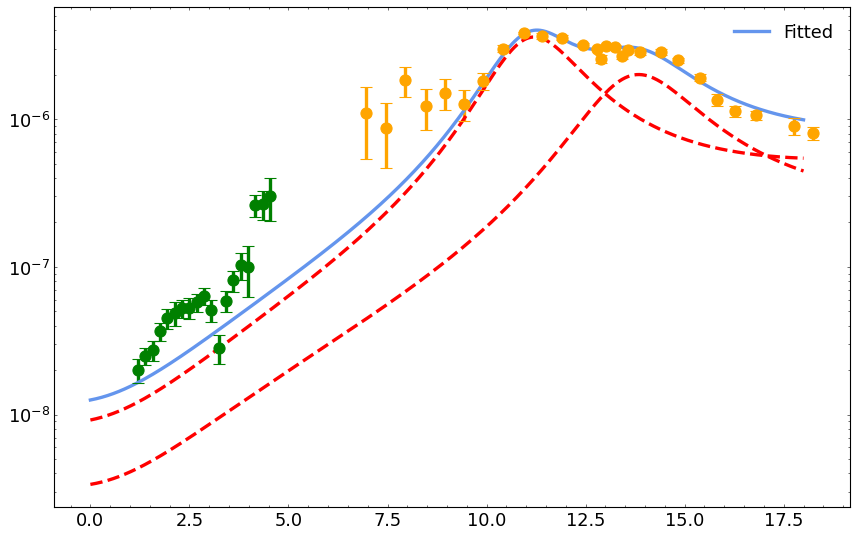

In [15]:
params_GLo = lmfit.Parameters()

#                (Name,          Value,  Weather or not to include in fit, 
#                 |              |       |     Lower fit limit, 
#                 |              |       |     |            Upper fit limit)
params_GLo.add_many(('T_f',          p0[0],  True, minimum[0],  maximum[0]),
                    ('E_GLo1',       p0[1],  True, minimum[1],  maximum[1]),
                    ('Gamma_GLo1',   p0[2],  True, minimum[2],  maximum[2]),
                    ('sigma_GLo1',   p0[3],  True, minimum[3],  maximum[3]),
                    ('E_GLo2',       p0[4],  True, minimum[4],  maximum[4]),
                    ('Gamma_GLo2',   p0[5],  True, minimum[5],  maximum[5]),
                    ('sigma_GLo2',   p0[6],  True, minimum[6],  maximum[6]),)

energy_GLo = all_data_energy[GLo_low_cut:]
data_GLo = all_data[GLo_low_cut:]
error_GLo = all_data_error[GLo_low_cut:]



def residuals_GLo(parameters):
    return (f_fit_GLo(parameters, energy_GLo) - data_GLo)**2/(error_GLo**2)

results_GLo = lmfit.minimize(fcn=residuals_GLo, params=params_GLo, method="leastsq")
print(results_GLo.params.pretty_print())

p0[0:7] = [results_GLo.params['T_f'].value, results_GLo.params['E_GLo1'].value, results_GLo.params['Gamma_GLo1'].value,
           results_GLo.params['sigma_GLo1'].value, results_GLo.params['E_GLo2'].value, results_GLo.params['Gamma_GLo2'].value,
           results_GLo.params['sigma_GLo2'].value]
update_params(params, p0)

plt.rcParams['text.usetex'] = False
# Initialize figure!
plt.figure(figsize=(11,7))
ax = plt.subplot(111)


# Actual best-fit curve
# Extract values from the fit
# Plot the total optimalized fit
x_values_cont = np.linspace(0, 18, 1000)
plot_fit = ax.plot(x_values_cont, f_fit_GLo(results_GLo.params, E=x_values_cont), '-', color="cornflowerblue", label="Fitted")
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=0), '--', color="red")
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=1), '--', color="red")
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='green')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='orange')
ax.legend()
ax.set_yscale('log')



Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_pyg1         4.311     1.35    11.25  0.08831     True     None     None
E_pyg2         8.003      2.1     17.5   0.7141     True     None     None
Gamma_pyg1    0.3651     0.12        1   0.2974     True     None     None
Gamma_pyg2      1.84     0.45     3.75   0.9353     True     None     None
T_f              0.5     0.06      0.5        0    False     None     None
sigma_pyg1     11.38      1.5     12.5    4.674     True     None     None
sigma_pyg2        50        6       50    3.202     True     None     None
None


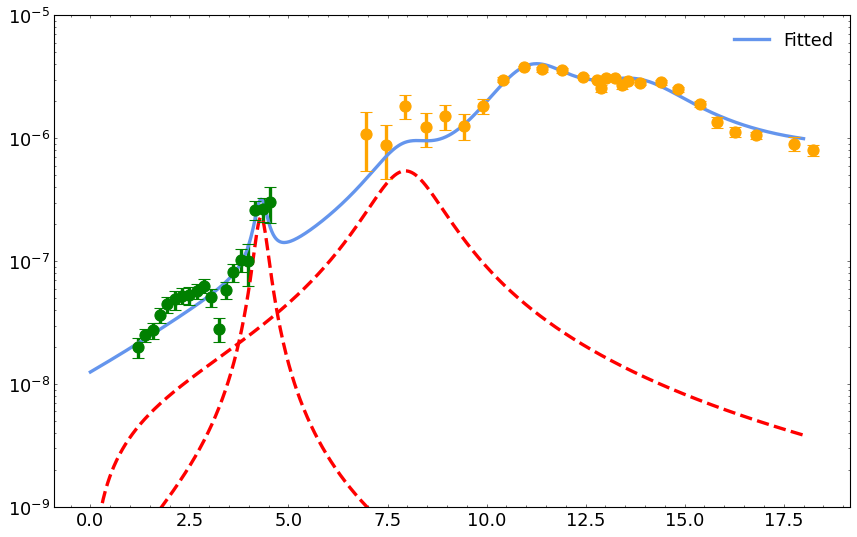

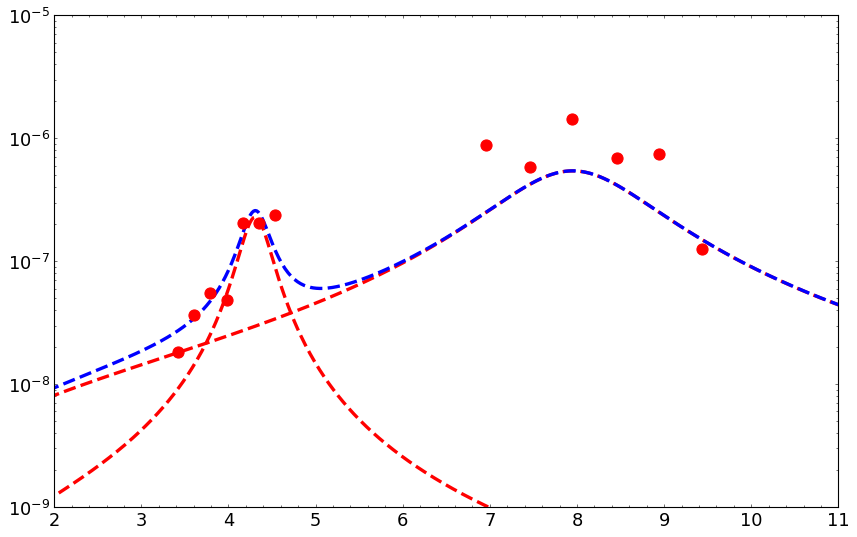

In [16]:
#Fit the pygmy resonances, in order to get the correct background for 
# the scissor resonance fit

params_pygs = lmfit.Parameters()

#                    (Name,          Value,  Weather or not to include in fit, 
#                     |              |       |     Lower fit limit, 
#                     |              |       |     |             Upper fit limit)
params_pygs.add_many(('T_f',         p0[0],  False, minimum[0],  maximum[0]),
                     ('E_pyg1',      p0[7],  True,  minimum[7],  maximum[7]),
                     ('Gamma_pyg1',  p0[8],  True,  minimum[8],  maximum[8]),
                     ('sigma_pyg1',  p0[9],  True,  minimum[9],  maximum[9]),
                     ('E_pyg2',      p0[10], True,  minimum[10], maximum[10]),
                     ('Gamma_pyg2',  p0[11], True,  minimum[11], maximum[11]),
                     ('sigma_pyg2',  p0[12], True,  minimum[12], maximum[12]))

energy_pyg = all_data_energy[pyg_low_cut:pyg_hi_cut]
data_pyg = all_data[pyg_low_cut:pyg_hi_cut]
error_pyg = all_data_error[pyg_low_cut:pyg_hi_cut]

for i in range(len(data_pyg)):
    if data_pyg[i]-f_fit_GLo(results_GLo.params, E=energy_pyg[i])<0:
        data_pyg[i] = 0
    else:
        data_pyg[i] = data_pyg[i]-f_fit_GLo(results_GLo.params, E=energy_pyg[i])

def residuals_pyg(parameters):
    return (f_fit_pygs(parameters, energy_pyg) - data_pyg)**2/(error_pyg**2)

results_pygs = lmfit.minimize(fcn=residuals_pyg, params=params_pygs, method="leastsq")
print(results_pygs.params.pretty_print())

p0[7:13] = [results_pygs.params['E_pyg1'].value, results_pygs.params['Gamma_pyg1'].value,
           results_pygs.params['sigma_pyg1'].value, results_pygs.params['E_pyg2'].value, results_pygs.params['Gamma_pyg2'].value,
           results_pygs.params['sigma_pyg2'].value]
update_params(params, p0)


plt.rcParams['text.usetex'] = False
# Initialize figure!
plt.figure(figsize=(11,7))
ax = plt.subplot(111)


# Actual best-fit curve
# Extract values from the fit
# Plot the total optimalized fit

x_values_cont = np.linspace(0, 18, 1000)
plot_fit = ax.plot(x_values_cont, f_fit_GLo(results_GLo.params, E=x_values_cont)+f_fit_pygs(results_pygs.params, E=x_values_cont), '-', color="cornflowerblue", label="Fitted")
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=2), '--', color="red")
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=3), '--', color="red")
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='green')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='orange')

ax.legend()
ax.set_ylim(1e-9,1e-5)
ax.set_yscale('log')


#plot only fit
plt.figure(figsize=(11,7))
ax = plt.subplot(111)
x_values_cont = np.linspace(0, 18, 1000)
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=2), '--', color="red")
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=3), '--', color="red")
ax.plot(x_values_cont, f_fit_pygs(params, x_values_cont), '--', color="blue")

ax.plot(energy_pyg, data_pyg, 'ro')
ax.set_ylim(1e-9,1e-5)
ax.set_xlim(2,11)
ax.set_yscale('log')

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_SR1         2.126      2.1      2.5  0.06733     True     None     None
E_SR2         2.734      2.5        3  0.08631     True     None     None
Gamma_SR1    0.5164     0.45     3.75   0.1396     True     None     None
Gamma_SR2      0.45     0.45     3.75  0.01168     True     None     None
T_f             0.5     0.06      0.5        0    False     None     None
sigma_SR1    0.4102      0.3      2.5  0.08846     True     None     None
sigma_SR2    0.3988      0.3      2.5   0.1202     True     None     None
None


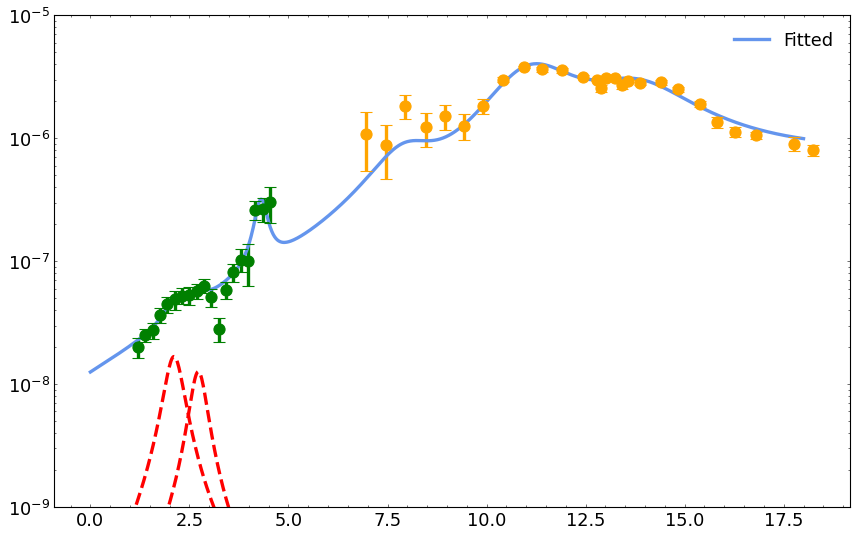

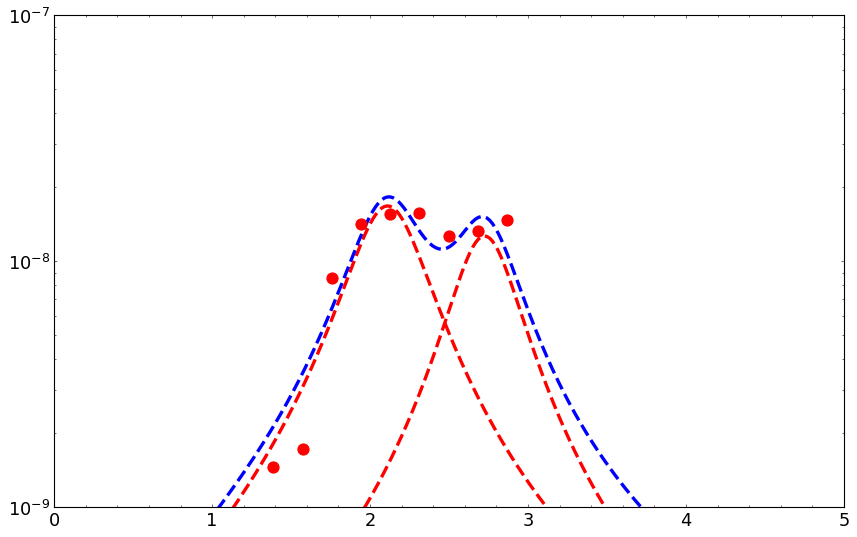

In [17]:
#Fit the pygmy resonances, in order to get the correct background for 
# the scissor resonance fit

params_SR = lmfit.Parameters()

#                    (Name,          Value,  Weather or not to include in fit, 
#                    |              |       |      Lower fit limit, 
#                    |              |       |      |             Upper fit limit)
params_SR.add_many(('T_f',          p0[0],   False, minimum[0],   maximum[0]),
                    ('E_SR1',       p0[13],  True,  2.1,  2.5),
                    ('Gamma_SR1',   p0[14],  True,  minimum[14],  maximum[14]),
                    ('sigma_SR1',   p0[15],  True,  minimum[15],  maximum[15]),
                    ('E_SR2',       p0[16],  True,  2.5,  3),
                    ('Gamma_SR2',   p0[17],  True,  minimum[17],  maximum[17]),
                    ('sigma_SR2',   p0[18],  True,  minimum[18],  maximum[18]))

energy_SR = all_data_energy[SR_low_cut:SR_hi_cut]
data_SR = all_data[SR_low_cut:SR_hi_cut]
error_SR = all_data_error[SR_low_cut:SR_hi_cut]

for i in range(len(data_SR)):
    if data_SR[i]-f_fit_GLo(results_GLo.params, E=energy_SR[i])-f_fit_pygs(results_pygs.params, E=energy_SR[i])<0:
        data_SR[i] = 0
    else:
        data_SR[i] = data_SR[i]-f_fit_GLo(results_GLo.params, E=energy_SR[i])-f_fit_pygs(results_pygs.params, E=energy_SR[i])

        
def residuals_SR(parameters):
    return (f_fit_SR(parameters, energy_SR) - data_SR)**2/(error_SR**2)

results_SR = lmfit.minimize(fcn=residuals_SR, params=params_SR, method="leastsq")
print(results_SR.params.pretty_print())
p0[13:] = [results_SR.params['E_SR1'].value, results_SR.params['Gamma_SR1'].value,
           results_SR.params['sigma_SR1'].value, results_SR.params['E_SR2'].value, results_SR.params['Gamma_SR2'].value,
           results_SR.params['sigma_SR2'].value]
update_params(params, p0)


plt.rcParams['text.usetex'] = False
# Initialize figure!
plt.figure(figsize=(11,7))
ax = plt.subplot(111)


# Actual best-fit curve
# Extract values from the fit
# Plot the total optimalized fit
x_values_cont = np.linspace(0, 18, 1000)
plot_fit = ax.plot(x_values_cont, f_fit_GLo(results_GLo.params, E=x_values_cont)+f_fit_pygs(results_pygs.params, E=x_values_cont)+f_fit_SR(results_SR.params, E=x_values_cont), '-', color="cornflowerblue", label="Fitted")
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=4), '--', color="red")
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=5), '--', color="red")
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='green')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='orange')

ax.set_ylim(1e-9,1e-5)
ax.legend()
ax.set_yscale('log')


#plot only fit
plt.figure(figsize=(11,7))
ax = plt.subplot(111)
x_values_cont = np.linspace(0, 18, 1000)
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=4), '--', color="red")
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=5), '--', color="red")
ax.plot(x_values_cont, f_fit_SR(params, x_values_cont), '--', color="blue")

ax.plot(energy_SR, data_SR, 'ro')
ax.set_ylim(1e-9,1e-7)
ax.set_xlim(0,5)
ax.set_yscale('log')


In [18]:
#extract all parameters for plotting

#Define parameters & start values for the GLO
E_GLo1 = results_GLo.params['E_GLo1'].value
Gamma_GLo1 = results_GLo.params['Gamma_GLo1'].value
sigma_GLo1 = results_GLo.params['sigma_GLo1'].value
E_GLo2 = results_GLo.params['E_GLo2'].value
Gamma_GLo2 = results_GLo.params['Gamma_GLo2'].value
sigma_GLo2 = results_GLo.params['sigma_GLo2'].value
T_f    = results_GLo.params['T_f'].value

#pygmy resonance 1
E_pyg1 = results_pygs.params['E_pyg1'].value
Gamma_pyg1 = results_pygs.params['Gamma_pyg1'].value
sigma_pyg1 = results_pygs.params['sigma_pyg1'].value

#pygmy 2/spinflip resonance
E_pyg2 = results_pygs.params['E_pyg2'].value
Gamma_pyg2 = results_pygs.params['Gamma_pyg1'].value
sigma_pyg2 = results_pygs.params['sigma_pyg1'].value

#extract parameters from fit
E_SR1 = results_SR.params['E_SR1'].value
E_SR1_err = results_SR.params['E_SR1'].stderr
Gamma_SR1 = results_SR.params['Gamma_SR1'].value
Gamma_SR1_err = results_SR.params['Gamma_SR1'].stderr
sigma_SR1 = results_SR.params['sigma_SR1'].value
sigma_SR1_err = results_SR.params['sigma_SR1'].stderr

E_SR2 = results_SR.params['E_SR2'].value
E_SR2_err = results_SR.params['E_SR2'].stderr
Gamma_SR2 = results_SR.params['Gamma_SR2'].value
Gamma_SR2_err = results_SR.params['Gamma_SR2'].stderr
sigma_SR2 = results_SR.params['sigma_SR2'].value
sigma_SR2_err = results_SR.params['sigma_SR2'].stderr


In [19]:
#function for plotting total
def fit_plot_tot(par, E):
    """ make_fit currently supports up to 5 GLO/SLOs. To add more, continue the pattern. This 
    was, suprisingly, the best solution I found atm working with the scipy-syntax. """

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2'],     par['E_pyg1'],     par['E_pyg2'],     par['E_SR1'],     par['E_SR2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2'], par['Gamma_pyg1'], par['Gamma_pyg2'], par['Gamma_SR1'], par['Gamma_SR2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2'], par['sigma_pyg1'], par['sigma_pyg2'], par['sigma_SR1'], par['sigma_SR2']])
    
    value = f_fit_GLo(results_GLo.params, E)+f_fit_pygs(results_pygs.params, E)+f_fit_SR(results_SR.params, E)
    return value

B(SR) (integral) = 4.709
B(SR2) (integral) = 5.256
B(SR) = 5.835


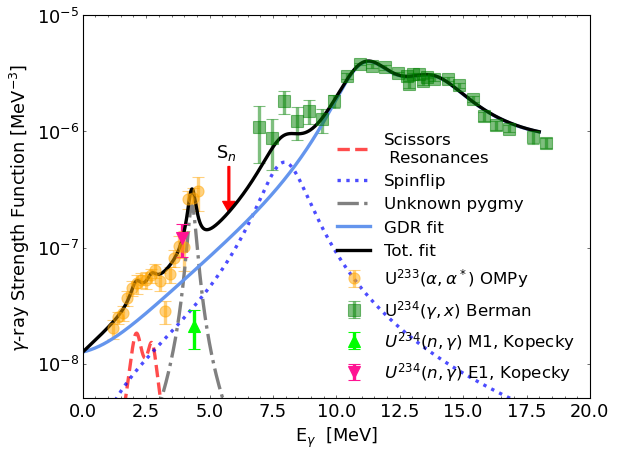

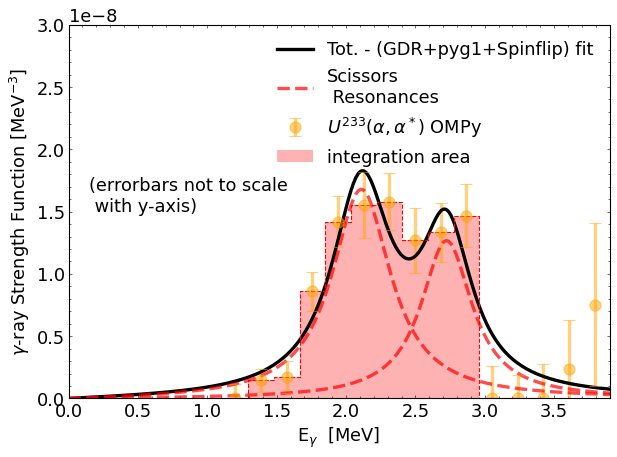

In [20]:
#Plotting total fit


x_values_cont = np.linspace(0, 18, 1000)

Sn = 5.762

plt.rcParams['text.usetex'] = False
fig, ax = plt.subplots(figsize=(8,6))

#Experimental Kopecky data
fEx = np.asarray([12.14E-08])
fEerr = np.asarray([3.92E-08])
fEene = np.asarray([3.9])
fEeneerr = np.asarray([0.00])
fMx = np.asarray([2.11E-08])
fMerr = np.asarray([0.78E-08])
fMene = np.asarray([4.4])
fMeneerr = np.asarray([0.0])



ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='orange', alpha=0.5, label='U$^{233}(\\alpha,\\alpha^*)$ OMPy')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='s', color='green', alpha=0.5, label="U$^{234}(\gamma,x)$ Berman ")
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=4)+fit_plot_singular(params, E=x_values_cont, j=5),'--', color="red", label='Scissors\n Resonances', alpha=0.7)

ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=3),':', color="blue", label='Spinflip', alpha=0.7)
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=2),'-.', color="gray", label='Unknown pygmy')
ax.plot(x_values_cont, f_fit_GLo(params, E=x_values_cont), '-', color="cornflowerblue", label="GDR fit")
ax.plot(x_values_cont, fit_plot_tot(params, E=x_values_cont), '-', color="Black", label="Tot. fit")


ax.errorbar(x=fMene, y=fMx, yerr=fMerr, xerr=None, fmt='^', color='lime', label="$U^{234}(n,\gamma)$ M1, Kopecky")
ax.errorbar(x=fEene, y=fEx, yerr=fEerr, xerr=None, fmt='v', color='deeppink', label="$U^{234}(n,\gamma)$ E1, Kopecky")
ax.set_yscale('log')
ax.set_xlabel('E$_\gamma$  [MeV]')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
    
ax.arrow(x=Sn, y=5e-7, dx=0, dy=-2.5e-7, width=0.08, head_width=.5, head_length=5e-8, color='r')
ax.text(Sn-.5, 6e-7, "S$_n$")    
    
    
ax.legend(fontsize=15)    
ax.set_ylim(5e-9, 1e-5)
ax.set_xlim(0, 20)
#ax.set_yscale('linear')
#ax2.set_ylim(1e-8, 1.5e-7)
#ax2.set_xlim(-3,5)
#ax2.set_yticks([1e-7])
ax.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')



fig, ax = plt.subplots(figsize=(8,6))
#f_fit_GLo(results_GLo.params, E=x_values_cont)-f_fit_pygs(results_pygs.params, E=x_values_cont)

extraction = f_fit_GLo(params, E=x_values_cont)+f_fit_pygs(params, E=x_values_cont)
extraction_ompy = f_fit_GLo(params, E=energy_gsf_ompy)+f_fit_pygs(params, E=energy_gsf_ompy)

#first, make sure negative points are set to zero in integral
for i in range(13):
    if gsf_ompy_median[i]-extraction_ompy[i]<0:
        gsf_ompy_median[i]=extraction_ompy[i]

        
def gsf_integral(energy):
    value = fit_plot_tot(params, E=energy)-f_fit_GLo(params, E=energy)-f_fit_pygs(params, E=energy)
    if value<0:
        return 0
    else:
        return value
    

integral = np.trapz(gsf_ompy_median[0:13]-extraction_ompy[0:13], energy_gsf_ompy[0:13])
B_SR = integral * 2.598e8
print('B(SR) (integral) = %.3f'%B_SR)
integral2 = integrate.quad(gsf_integral,0.5,4)
B_SR = integral2[0] * 2.598e8
print('B(SR2) (integral) = %.3f'%B_SR)
B_SR_old = 35.31 * (sigma_SR1 * Gamma_SR1 / (E_SR1) + sigma_SR2 * Gamma_SR2 / (E_SR2))
print('B(SR) = %.3f'%B_SR_old)



ax.plot(x_values_cont, fit_plot_tot(params, E=x_values_cont)-extraction,
        '-', color="Black", label="Tot. - (GDR+pyg1+Spinflip) fit")
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=4),'--', color="red", label='Scissors\n Resonances', alpha=0.7)
ax.plot(x_values_cont, fit_plot_singular(params, E=x_values_cont, j=5),'--', color="red", alpha=0.7)

ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median-extraction_ompy,
            yerr=gsf_ompy_error*0.3, 
            fmt='o', color='orange', alpha=0.5, label='$U^{233}(\\alpha,\\alpha^*)$ OMPy')

ax.bar(energy_gsf_ompy[0:13], width=0.185, height=gsf_ompy_median[0:13]-extraction_ompy[0:13], align='center',label='integration area', alpha=.3, color='red')
ax.step(energy_gsf_ompy[0:13], gsf_ompy_median[0:13]-extraction_ompy[0:13], where='mid', color='red', linewidth=1, linestyle='--')

ax.set_ylabel('$\gamma$-ray Strength Function [MeV$^{-3}$]')
ax.set_xlabel('E$_\gamma$  [MeV]')
ax.set_ylim(0, 3e-8)
ax.set_xlim(0,3.9)
ax.text(0.15, 1.5e-8,'(errorbars not to scale \n with y-axis)')
ax.legend();

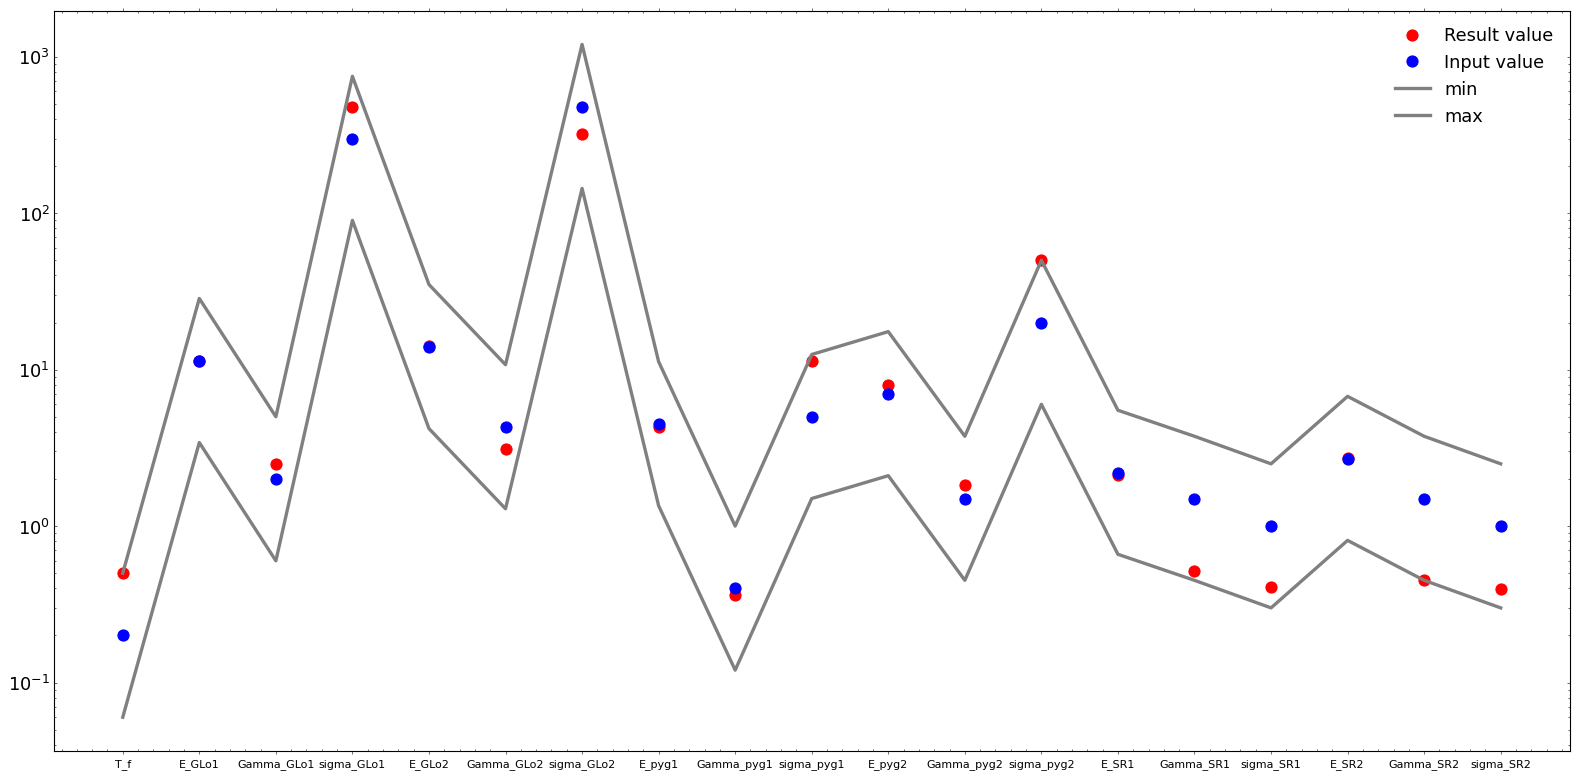

In [21]:
debug_mode=1
if debug_mode:
    """ This plots out the initial guess and optimised parameters and their min/max limits for the fit.
    This is meant to """
    fig, ax = plt.subplots(figsize=(20,10))
    
    D = input_params.valuesdict()
    X = range(len(D))
    R = params.valuesdict()
    ax.plot(X, list(R.values()), 'ro', label='Result value')
    ax.plot(X, list(D.values()), 'bo', label='Input value')
    
    ax.plot(X, minimum, color="grey", label="min")
    ax.plot(X, maximum, color="grey", label="max")

    
    ax.set_xticks(X)
    ax.tick_params(axis='x', which='major', labelsize=10, direction='out')
    ax.set_xticklabels(list(R.keys()))
    
    ax.set_yscale("log")
    ax.legend()
    fig.show()